In [1]:
import os
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Callable, Union
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Setup logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ImageClassificationDataset(Dataset):
    """Custom Dataset for loading images from folders with lazy loading."""

    def __init__(self,
                 root_dir: str,
                 transform: Optional[Callable] = None,
                 target_size: Tuple[int, int] = (360, 360)):
        """
        Args:
            root_dir: Path to the dataset directory with class folders
            transform: Optional transforms to apply to images
            target_size: Size to resize images to (width, height)
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.target_size = target_size

        # Get all image paths and their corresponding labels
        self.samples = []
        self.class_to_idx = {}
        self.classes = []

        # Scan the directory structure
        for class_idx, class_dir in enumerate(sorted(os.listdir(self.root_dir))):
            class_path = self.root_dir / class_dir

            # Skip if not a directory
            if not class_path.is_dir():
                continue

            self.classes.append(class_dir)
            self.class_to_idx[class_dir] = class_idx

            # Find all image files in this class directory
            for img_path in class_path.glob("*.*"):
                # Filter for common image extensions
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    self.samples.append((str(img_path), class_idx))

        logger.info(f"Found {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Lazy load images only when accessed.
        Handles corrupt images gracefully.
        """
        img_path, label = self.samples[idx]

        try:
            # Load and convert image only when accessed
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB to ensure consistency
                img = img.resize(self.target_size)  # Resize to target size

                if self.transform:
                    img = self.transform(img)
                else:
                    # Default transform to tensor if none provided
                    img = transforms.ToTensor()(img)

                return img, label

        except (UnidentifiedImageError, OSError, IOError) as e:
            logger.warning(f"Error loading image {img_path}: {str(e)}")
            # Return a black image with the same shape instead of failing
            black_img = torch.zeros(3, self.target_size[1], self.target_size[0])
            return black_img, label

def create_data_loaders(
    dataset_path: str,
    batch_size: int = 32,
    train_ratio: float = 0.7,
    val_ratio: float = 0.2,
    test_ratio: float = 0.1,
    num_workers: int = 4,
    target_size: Tuple[int, int] = (360, 360),
    random_seed: int = 42
) -> Dict[str, DataLoader]:
    """
    Create train, validation and test data loaders with proper transforms.

    Args:
        dataset_path: Path to dataset directory
        batch_size: Batch size for loaders
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
        test_ratio: Proportion of data for testing
        num_workers: Number of worker processes for data loading
        target_size: Size to resize images to
        random_seed: Random seed for reproducibility

    Returns:
        Dictionary containing train, val, and test DataLoaders
    """
    # Verify ratios
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-10:
        raise ValueError("Train, validation, and test ratios must sum to 1")

    # Set random seeds for reproducibility
    torch.manual_seed(random_seed)
    random.seed(random_seed)

    # # Define transforms for training (with augmentation)
    # train_transform = transforms.Compose([
    #     transforms.RandomResizedCrop(target_size),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])
    # train_transform = transforms.Compose([
    #     # Spatial transformations
    #     transforms.RandomResizedCrop(target_size, scale=(0.8, 1.0)),  # More conservative crop
    #     transforms.RandomHorizontalFlip(p=0.5),
    #     transforms.RandomRotation(5),  # Slight rotation (rooms are usually oriented upright)
    #     transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Simulate different viewing angles
    #
    #     # Color/appearance transformations
    #     transforms.ColorJitter(
    #         brightness=0.2,
    #         contrast=0.2,
    #         saturation=0.2,
    #         hue=0.05  # Small hue changes (lighting can change color temperature)
    #     ),
    #     transforms.RandomGrayscale(p=0.02),  # Occasionally convert to grayscale
    #     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Simulate focus issues
    #
    #     # Lighting simulation
    #     transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    #
    #     # Normalization
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #
    #     # Optional: random erasing (simulates occlusion)
    #     transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    # ])
    train_transform = transforms.Compose([
        transforms.Resize((target_size[0] + 32, target_size[1] + 32)),
        transforms.RandomCrop(target_size[0]),
        transforms.RandomHorizontalFlip(),  # Interior designs often have horizontal symmetry
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),  # Subtle color changes
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small geometric changes
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),  # Simulates furniture/object removal
    ])

    # Define transforms for validation and testing (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create the full dataset (only metadata, images aren't loaded yet)
    full_dataset = ImageClassificationDataset(
        root_dir=dataset_path,
        transform=None,  # We'll apply transforms after splitting
        target_size=target_size
    )

    # Calculate split sizes
    dataset_size = len(full_dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)
    )

    # Create wrapped datasets with appropriate transforms
    class TransformWrapper(Dataset):
        def __init__(self, dataset, transform):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            img, label = self.dataset[idx]
            # If img is already a tensor (from error handling), convert back to PIL
            if isinstance(img, torch.Tensor):
                # Convert tensor back to PIL for transform
                if img.shape[0] == 3:  # If it's already in CxHxW format
                    img = transforms.ToPILImage()(img)
                else:
                    # Handle unexpected tensor format
                    img = Image.new('RGB', target_size, color=0)
            return self.transform(img), label

    # Wrap datasets with appropriate transforms
    train_dataset_transformed = TransformWrapper(train_dataset, train_transform)
    val_dataset_transformed = TransformWrapper(val_dataset, eval_transform)
    test_dataset_transformed = TransformWrapper(test_dataset, eval_transform)

    logger.info(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

    # Create data loaders with appropriate settings
    train_loader = DataLoader(
        train_dataset_transformed,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=(num_workers > 0)
    )

    val_loader = DataLoader(
        val_dataset_transformed,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0)
    )

    test_loader = DataLoader(
        test_dataset_transformed,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0)
    )

    return {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
        "classes": full_dataset.classes,
        "class_to_idx": full_dataset.class_to_idx
    }


def get_dataset_stats(dataset_path: str, sample_size: int = 1000) -> Dict[str, List[float]]:
    """
    Calculate dataset mean and std by sampling (to avoid loading all images).

    Args:
        dataset_path: Path to dataset directory
        sample_size: Number of images to sample for statistics

    Returns:
        Dictionary with mean and std values
    """
    dataset = ImageClassificationDataset(
        root_dir=dataset_path,
        transform=transforms.ToTensor()
    )

    # Sample images to calculate mean and std
    indices = random.sample(range(len(dataset)), min(sample_size, len(dataset)))
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for i, idx in enumerate(indices):
        try:
            img, _ = dataset[idx]
            mean += img.mean(dim=(1, 2))
            std += img.std(dim=(1, 2))
        except Exception as e:
            logger.warning(f"Error processing image for stats: {e}")

    mean /= len(indices)
    std /= len(indices)

    return {
        "mean": mean.tolist(),
        "std": std.tolist()
    }


if __name__ == "__main__":
    # Example usage
    dataset_path = "/mnt/e/IT/AI/Dataset/Design_Dataset"

    # Optional: Calculate dataset statistics for normalization
    # stats = get_dataset_stats(dataset_path)
    # print(f"Dataset statistics: Mean={stats['mean']}, Std={stats['std']}")

    # Create data loaders
    loaders = create_data_loaders(
        dataset_path=dataset_path,
        batch_size=32,
        num_workers=6,  # Adjust based on your CPU cores
        target_size=(384, 384)
    )

    # Print dataset information
    print(f"Classes: {loaders['classes']}")
    print(f"Train batches: {len(loaders['train'])}")
    print(f"Validation batches: {len(loaders['val'])}")
    print(f"Test batches: {len(loaders['test'])}")

    # Example: Iterate through one batch
    for images, labels in loaders['train']:
        print(f"Batch shape: {images.shape}")
        print(f"Labels: {labels}")
        break  # Just show the first batch

2025-04-29 13:27:35.164386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745933255.243179  178068 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745933255.267535  178068 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745933255.441462  178068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745933255.441489  178068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745933255.441491  178068 computation_placer.cc:177] computation placer alr

Classes: ['Asian', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Mid-century-modern', 'Modern', 'Rustic', 'Scandinavian', 'Traditional']
Train batches: 258
Validation batches: 74
Test batches: 37
Batch shape: torch.Size([32, 3, 384, 384])
Labels: tensor([ 8,  1,  8,  8, 11,  7,  4,  3,  4,  3,  1,  2,  8, 11,  8,  4, 10,  8,
        10,  5,  7,  6,  6,  0,  5,  1,  3, 11,  0, 10,  1,  1])


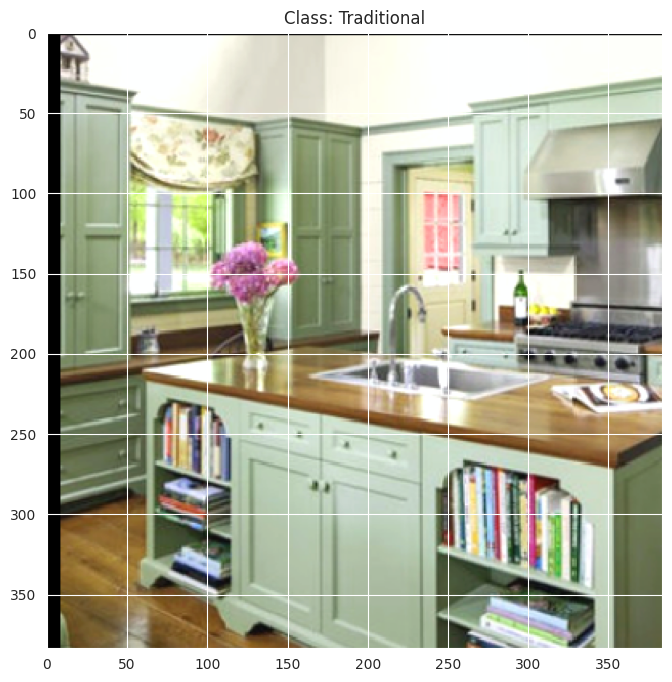

Image shape: (384, 384, 3)
Class: Traditional (index: 11)


In [7]:
def show_image_from_dataset(dataset_loader, class_names, batch_index=0, image_index=0):
    """
    Display an image from a PyTorch DataLoader.

    Args:
        dataset_loader: PyTorch DataLoader
        class_names: List of class names
        batch_index: Index of the batch to display (default: 0)
        image_index: Index of the image within the batch to display (default: 0)
    """
    # Check if we're getting a DataLoader or a Dataset
    if hasattr(dataset_loader, 'dataset'):
        # It's a DataLoader, get the dataset
        is_dataloader = True
    else:
        # It's already a Dataset
        is_dataloader = False

    try:
        if is_dataloader:
            # Method for DataLoader - we need to iterate through batches
            for i, (images, labels) in enumerate(dataset_loader):
                if i == batch_index:
                    # Found the requested batch
                    if image_index >= len(images):
                        print(f"Error: Image index {image_index} out of range for batch with {len(images)} images")
                        return

                    # Get the specific image and label
                    img = images[image_index]
                    label = labels[image_index]

                    # Display the image
                    display_image(img, label, class_names)
                    return

            # If we get here, the batch wasn't found
            print(f"Error: Batch {batch_index} not found in dataset with {len(dataset_loader)} batches")

        else:
            # Method for direct Dataset access
            # Calculate the absolute index
            absolute_idx = batch_index * 64 + image_index  # Assuming batch size of 64, adjust as needed

            if absolute_idx >= len(dataset_loader):
                print(f"Error: Index {absolute_idx} out of range for dataset with {len(dataset_loader)} images")
                return

            # Get the image and label directly
            img, label = dataset_loader[absolute_idx]
            display_image(img, label, class_names)

    except Exception as e:
        print(f"Error displaying image: {str(e)}")

def display_image(img, label, class_names):
    """Helper function to display and format the image"""
    # Convert tensor to numpy for display
    if isinstance(img, torch.Tensor):
        # If image is a tensor in CxHxW format (PyTorch standard)
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Change to HxWxC format

        # Denormalize if image was normalized
        # Assuming standard normalization with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean

        # Clip values to valid range
        img_np = np.clip(img_np, 0, 1)
    else:
        img_np = np.array(img)

    # Handle label type
    if isinstance(label, torch.Tensor):
        label_idx = label.item()
    else:
        label_idx = label

    # Get class name
    if label_idx < len(class_names):
        class_name = class_names[label_idx]
    else:
        class_name = f"Unknown (index {label_idx})"

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Class: {class_name}")
    plt.axis('on')
    plt.show()

    print(f"Image shape: {img_np.shape}")
    print(f"Class: {class_name} (index: {label_idx})")

# Example using a DataLoader
show_image_from_dataset(
    dataset_loader=loaders['train'],  # Your train loader from previous code
    class_names=loaders['classes'],   # Class names from your loader
    batch_index=0,                    # First batch
    image_index=8                     # Fourth image in the batch
)

In [10]:
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import cv2
from PIL import Image

class AttentionBlock(nn.Module):
    def __init__(self, in_features, reduction_factor=16):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_features, in_features//reduction_factor, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_features//reduction_factor, in_features, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class MixUpTransform:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, batch):
        inputs, targets = batch
        batch_size = inputs.size(0)

        # Generate mixing coefficients
        lam = np.random.beta(self.alpha, self.alpha, batch_size)
        lam = torch.tensor(lam, dtype=torch.float32).to(inputs.device)
        lam = lam.view(-1, 1, 1, 1)

        # Mix images
        index = torch.randperm(batch_size).to(inputs.device)
        mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]

        # Return mixed images and both targets
        return mixed_inputs, targets, targets[index], lam.squeeze()

def build_fine_grained_model(num_classes, device):
    """
    Build a model with ConvNeXt-Small and attention mechanisms for fine-grained classification.

    Args:
        num_classes: Number of output classes
        device: The device to put the model on (cuda/cpu)

    Returns:
        model: The complete model
    """
    # Use ConvNeXt-Small for better feature extraction
    model = models.convnext_small(weights='DEFAULT')

    # Extract feature dimensions
    feature_dim = 768  # For ConvNeXt-Small

    # Add attention mechanism to the last feature map
    model.features.append(AttentionBlock(feature_dim))

    # Replace classifier with a more sophisticated head
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.LayerNorm(feature_dim),
        nn.Dropout(p=0.3),
        nn.Linear(feature_dim, 512),
        nn.GELU(),
        nn.LayerNorm(512),
        nn.Dropout(p=0.4),
        nn.Linear(512, num_classes)
    )

    # Move model to device
    model = model.to(device)
    return model

def get_class_weights(data_loader):
    """
    Calculate class weights to handle class imbalance.

    Args:
        data_loader: PyTorch DataLoader for training set

    Returns:
        class_weights: Tensor of class weights
    """
    # Extract all labels from the training dataset
    all_labels = []
    for _, labels in data_loader:
        all_labels.extend(labels.numpy())

    # Count class occurrences
    class_counts = Counter(all_labels)
    classes = sorted(class_counts.keys())

    # Use scikit-learn's compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=all_labels
    )

    # Convert to PyTorch tensor
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    class_weights = torch.FloatTensor(class_weights).to(device)
    return class_weights

def train_model_with_mixup(model, dataloaders, criterion, optimizer, scheduler,
                          device, mixup=None, num_epochs=25, phase_name="Training"):
    """
    Train a PyTorch model with optional MixUp augmentation.

    Args:
        model: PyTorch model
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to train on
        mixup: MixUp transform (optional)
        num_epochs: Number of epochs
        phase_name: Name of training phase for logging

    Returns:
        model: Best model based on validation accuracy
        history: Training history
    """
    since = time.time()

    # Deep copy of best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # History to track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    # Early stopping parameters
    patience = 7
    min_delta = 0.001
    counter = 0
    best_val_loss = float('inf')

    # Enable automatic mixed precision for memory optimization
    scaler = torch.amp.GradScaler(device.type)

    for epoch in range(num_epochs):
        print(f'{phase_name} - Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Log current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        print(f'Learning Rate: {current_lr:.1e}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply MixUp in training if provided
                if phase == 'train' and mixup is not None:
                    mixed_inputs, targets_a, targets_b, lam = mixup((inputs, labels))
                    inputs = mixed_inputs

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass with mixed precision
                with torch.amp.autocast(device.type):
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)

                        # Apply MixUp loss if used
                        if phase == 'train' and mixup is not None:
                            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                            loss = loss.mean() # Make sure loss is scalar
                            # For accuracy calculation when using mixup
                            corrects = lam * (preds == targets_a).float() + (1 - lam) * (preds == targets_b).float()
                            running_corrects += corrects.sum()
                        else:
                            loss = criterion(outputs, labels)
                            loss = loss.mean()
                            corrects = (preds == labels).float().sum()
                            running_corrects += corrects

                        # Backward + optimize only in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Step LR scheduler based on validation performance
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                else:
                    scheduler.step()

                # Early stopping check
                if epoch_loss < best_val_loss - min_delta:
                    best_val_loss = epoch_loss
                    counter = 0
                    # Save best model weights
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered after {epoch+1} epochs!")
                        # Load best model weights
                        model.load_state_dict(best_model_wts)
                        return model, history

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def train_interior_design_classifier(output_dir="design_classifier_checkpoints", device=None):
    """
    Complete training pipeline for interior design style classification.

    Args:
        output_dir: Directory to save model checkpoints
        device: Device to train on (defaults to GPU if available)

    Returns:
        model: Trained model
        combined_history: Training history from all phases
    """
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # # Create dataloaders with augmentation
    # loaders = get_augmented_dataloaders(data_dir, batch_size=32, img_size=384)

    # Get number of classes and class names
    class_names = loaders['classes']
    num_classes = len(class_names)
    print(f"Training classifier for {num_classes} classes: {class_names}")

    # Calculate class weights for handling imbalance
    try:
        class_weights = get_class_weights(loaders['train'])
        print("Class weights:", class_weights)
    except Exception as e:
        print(f"Could not compute class weights: {e}")
        class_weights = None

    # Initialize model with fine-grained classification features
    model = build_fine_grained_model(num_classes, device)

    # Combined history
    combined_history = {}

    # Set up training phases
    phases = [
        {
            'name': 'Initial Training',
            'lr': 1e-3,
            'epochs': 25,
            'unfreeze_blocks': 0,  # Only train classifier
            'loss': 'cross_entropy',
            'use_mixup': True
        },
        {
            'name': 'Fine-tune Style Features',
            'lr': 5e-4,
            'epochs': 20,
            'unfreeze_blocks': 3,  # Unfreeze last 3 blocks
            'loss': 'focal',
            'use_mixup': True
        },
        {
            'name': 'Full Fine-tuning',
            'lr': 1e-5,
            'epochs': 15,
            'unfreeze_blocks': 5,  # All layers
            'loss': 'focal',
            'use_mixup': False
        }
    ]

    # Training with optional mixup
    mixup = MixUpTransform(alpha=0.2)

    for i, phase in enumerate(phases):
        print(f"\nSTARTING PHASE {i+1}: {phase['name']}")

        # Unfreeze specified blocks
        if phase['unfreeze_blocks'] == 0:
            # Freeze all backbone parameters
            for param in model.parameters():
                param.requires_grad = False
            # Unfreeze classifier
            for param in model.classifier.parameters():
                param.requires_grad = True
            print("Training only classifier layers")
        elif phase['unfreeze_blocks'] == -1:
            # Unfreeze all parameters
            for param in model.parameters():
                param.requires_grad = True
            print("Training all layers")
        else:
            # Freeze all backbone parameters first
            for param in model.parameters():
                param.requires_grad = False
            # Unfreeze classifier
            for param in model.classifier.parameters():
                param.requires_grad = True

            # Count model blocks for proper unfreezing
            blocks = list(model.features.children())
            total_blocks = len(blocks)
            blocks_to_unfreeze = min(phase['unfreeze_blocks'], total_blocks)
            last_n_blocks = blocks[-blocks_to_unfreeze:]

            print(f"Unfreezing last {blocks_to_unfreeze} feature blocks out of {total_blocks}")
            for block in last_n_blocks:
                for param in block.parameters():
                    param.requires_grad = True

        # Setup optimizer with weight decay
        optimizer = optim.AdamW([
            {'params': [p for n, p in model.named_parameters() if p.requires_grad and 'classifier' not in n],
             'lr': phase['lr'] * 0.1, 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if p.requires_grad and 'classifier' in n],
             'lr': phase['lr'], 'weight_decay': 0.01}
        ])

        # Use cosine annealing scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=5, T_mult=2, eta_min=1e-6
        )

        # Choose loss function
        if phase['loss'] == 'cross_entropy':
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:  # 'focal'
            criterion = FocalLoss(alpha=1, gamma=2, weight=class_weights)

        # Train the model for this phase
        model, history = train_model_with_mixup(
            model,
            {'train': loaders['train'], 'val': loaders['val']},
            criterion,
            optimizer,
            scheduler,
            device,
            mixup if phase['use_mixup'] else None,
            num_epochs=phase['epochs'],
            phase_name=f"Phase {i+1}"
        )

        combined_history[f'phase{i+1}'] = history

        # Save checkpoint
        torch.save(model.state_dict(), output_dir / f"design_classifier_phase{i+1}.pth")

    # Save final model
    torch.save(model.state_dict(), output_dir / "design_classifier_final.pth")
    torch.save(model, output_dir / "design_classifier_full_model.pth")

    # Plot training history
    plot_training_history(combined_history, output_dir / "training_history.png")

    return model, combined_history

def plot_training_history(history, save_path):
    """
    Plot training and validation loss/accuracy history.

    Args:
        history: Dictionary containing training history
        save_path: Path to save the plot
    """
    plt.figure(figsize=(12, 8))

    # Plot accuracy for each phase
    plt.subplot(2, 1, 1)
    for phase in history:
        epochs = range(1, len(history[phase]['train_acc']) + 1)
        plt.plot(epochs, history[phase]['train_acc'], 'b-', label=f'{phase} Train')
        plt.plot(epochs, history[phase]['val_acc'], 'r-', label=f'{phase} Val')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss for each phase
    plt.subplot(2, 1, 2)
    for phase in history:
        epochs = range(1, len(history[phase]['train_loss']) + 1)
        plt.plot(epochs, history[phase]['train_loss'], 'b-', label=f'{phase} Train')
        plt.plot(epochs, history[phase]['val_loss'], 'r-', label=f'{phase} Val')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def visualize_class_activation_maps(model, img_path, transform, target_class=None):
    """
    Visualize class activation maps to see what regions the model focuses on.

    Args:
        model: Trained PyTorch model
        img_path: Path to input image
        transform: Image transformation pipeline
        target_class: Target class index (optional, uses predicted class if None)

    Returns:
        visualization: Visualization of CAM overlaid on original image
    """
    model.eval()

    # Load and process image
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)

    # Register hooks for feature maps
    feature_maps = []

    # Find the last convolutional layer in the model
    last_conv_layer = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv_layer = module

    def hook_func(module, input, output):
        feature_maps.append(output.detach())

    hook = last_conv_layer.register_forward_hook(hook_func)

    # Forward pass
    outputs = model(img_tensor)

    # Get predicted class if not specified
    if target_class is None:
        target_class = outputs.argmax(dim=1).item()

    # Get score for target class
    score = outputs[0, target_class]

    # Backward pass to get gradients
    model.zero_grad()
    score.backward()

    # Get gradients
    gradients = []
    for param in last_conv_layer.parameters():
        if param.grad is not None:
            gradients.append(param.grad.detach())

    # Remove hook
    hook.remove()

    # Get feature maps from the last convolutional layer
    feature_map = feature_maps[0]

    # Calculate channel-wise weights using global average pooling
    weights = torch.mean(gradients[0], dim=[2, 3])

    # Weight feature maps and sum
    batch_size, num_channels, height, width = feature_map.shape
    cam = torch.zeros(height, width).to(feature_map.device)

    for i, w in enumerate(weights[0]):
        cam += w * feature_map[0, i]

    # Apply ReLU
    cam = F.relu(cam)

    # Normalize
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # Convert to numpy and resize to input image size
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (img.width, img.height))

    # Convert image to numpy array
    img_np = np.array(img)

    # Apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    result = heatmap * 0.3 + img_np * 0.7
    result = result.astype(np.uint8)

    # Create figure with original and CAM
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f'Class Activation Map (Class {target_class})')
    plt.axis('off')

    return result

def predict_design_style(model, img_path, transform, class_names):
    """
    Predict interior design style for a given image.

    Args:
        model: Trained PyTorch model
        img_path: Path to input image
        transform: Image transformation pipeline
        class_names: List of class names

    Returns:
        predictions: Dictionary with predicted class and probabilities
    """
    model.eval()

    # Load and process image
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)

    # Get predictions
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]

    # Get top predictions
    top_probs, top_indices = torch.topk(probabilities, 3)

    # Create result dictionary
    predictions = {
        'top_prediction': class_names[top_indices[0].item()],
        'top_probability': top_probs[0].item(),
        'top_3': [(class_names[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)]
    }

    return predictions


# Example usage
output_dir = "design_classifier_results/V4"

# Train the model
model, history = train_interior_design_classifier(output_dir)

Using device: cuda:0
Training classifier for 12 classes: ['Asian', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Mid-century-modern', 'Modern', 'Rustic', 'Scandinavian', 'Traditional']
Could not compute class weights: The 'classes' parameter of compute_class_weight must be an instance of 'numpy.ndarray'. Got [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)] instead.

STARTING PHASE 1: Initial Training
Training only classifier layers
Phase 1 - Epoch 1/25
----------
Learning Rate: 1.0e-04
train Loss: 2.4743 Acc: 0.1978
val Loss: 2.0805 Acc: 0.3582

Phase 1 - Epoch 2/25
----------
Learning Rate: 9.1e-05
train Loss: 2.3402 Acc: 0.2867
val Loss: 2.0332 Acc: 0.3514

Phase 1 - Epoch 3/25
----------
Learning Rate: 6.6e-05
train Loss: 2.3197 Acc: 0.3068
val Loss: 1.9794 Acc: 0.3896

Phase 1 - Epoch 4/25
----------
Learning Rate: 3.5e-05
train Loss:

KeyboardInterrupt: 

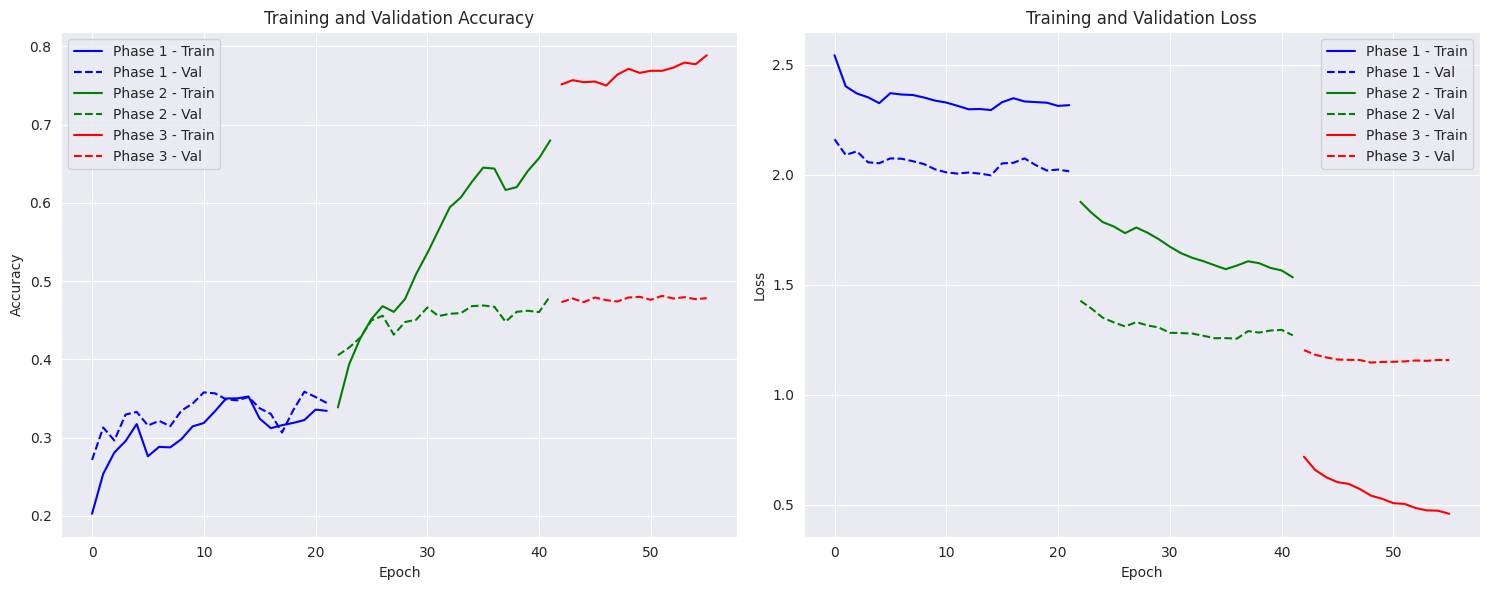

Test Accuracy: 47.80%


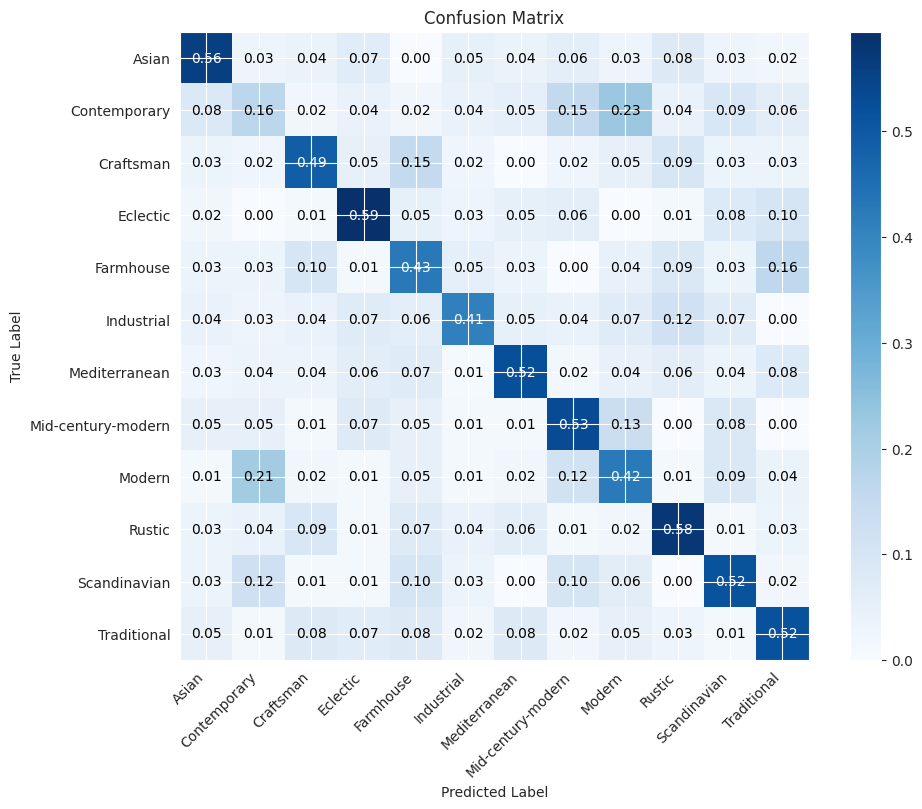

Final test accuracy: 47.80%
Model saved to room_classifier_final_model.pth


In [6]:
def plot_training_history(combined_history):
    """
    Plot the training history from all phases.

    Args:
        combined_history: Dictionary containing training history from all phases
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = ['b', 'g', 'r']
    phases = ['phase1', 'phase2', 'phase3']
    phase_names = ['Phase 1', 'Phase 2', 'Phase 3']

    # Track epoch count for x-axis
    current_epoch = 0

    # Plot training and validation accuracy/loss
    for i, phase in enumerate(phases):
        if phase not in combined_history:
            continue

        history = combined_history[phase]
        epochs = range(current_epoch, current_epoch + len(history['train_acc']))

        # Plot accuracy
        ax1.plot(epochs, history['train_acc'], f'{colors[i]}-',
                 label=f'{phase_names[i]} - Train')
        ax1.plot(epochs, history['val_acc'], f'{colors[i]}--',
                 label=f'{phase_names[i]} - Val')

        # Plot loss
        ax2.plot(epochs, history['train_loss'], f'{colors[i]}-',
                 label=f'{phase_names[i]} - Train')
        ax2.plot(epochs, history['val_loss'], f'{colors[i]}--',
                 label=f'{phase_names[i]} - Val')

        # Update current epoch
        current_epoch += len(history['train_acc'])

    # Set titles and labels
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set.

    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test set
        device: Device to evaluate on

    Returns:
        test_accuracy: Accuracy on test set
    """
    model.eval()
    correct = 0
    total = 0

    # Confusion matrix
    num_classes = len(test_loader.dataset.dataset.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Normalize confusion matrix by row
    confusion_matrix = confusion_matrix / confusion_matrix.sum(1, keepdim=True)

    return accuracy, confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_names):
    """
    Plot the confusion matrix.

    Args:
        confusion_matrix: PyTorch tensor containing confusion matrix
        class_names: List of class names
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, f'{confusion_matrix[i, j]:.2f}',
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot training history
plot_training_history(history)
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Evaluate on test set
accuracy, conf_matrix = evaluate_model(model, loaders['test'], device)

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, loaders['classes'])

print(f"Final test accuracy: {accuracy:.2f}%")